In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Membaca Dataset .mat

In [ ]:
from IPython import get_ipython
from IPython.display import display
import pandas as pd
import h5py
import numpy as np
import glob

mat_files = glob.glob("/content/drive/MyDrive/brainTumorDataPublic/*.mat")
data_list = []

for file in mat_files:
    try:
        with h5py.File(file, 'r') as f:
            cjdata = f['cjdata']
            pid_ascii = cjdata['PID'][()]
            pid = ''.join(chr(c) for c in pid_ascii.flatten())

            label = int(cjdata['label'][()][0][0])
            image_shape = cjdata['image'].shape
            tumor_mask = cjdata['tumorMask'][()]
            tumor_size = int(np.sum(tumor_mask))

            data_list.append({
                'PID': pid,
                'Label': label,
                'ImageShape': image_shape,
                'TumorSize': tumor_size
            })
    except Exception as e:
        print(f"Error processing file {file}: {e}")

df = pd.DataFrame(data_list)
df.head()

,PID,Label,ImageShape,TumorSize
0,MR051644B,2,"(512, 512)",9288
1,MR051651B,2,"(512, 512)",2397
2,MR051644B,2,"(512, 512)",14597
3,MR051644B,2,"(512, 512)",11839
4,MR051644C,2,"(512, 512)",4897


Preprocessing Data

In [ ]:
print("Missing values per column:")
print(df.isnull().sum())

print("\nNumber of duplicate rows:")
print(df.duplicated().sum())

if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True)
    print("\nDuplicate rows removed.")

print("\nDataFrame after preprocessing:")
print(df.head())

Missing values per column:
PID           0
Label         0
ImageShape    0
TumorSize     0
dtype: int64

Number of duplicate rows:
7

Duplicate rows removed.

DataFrame after preprocessing:
         PID  Label  ImageShape  TumorSize
0  MR051644B      2  (512, 512)       9288
1  MR051651B      2  (512, 512)       2397
2  MR051644B      2  (512, 512)      14597
3  MR051644B      2  (512, 512)      11839
4  MR051644C      2  (512, 512)       4897


Mengubah File .mat Menjadi .png

In [ ]:
import os
import h5py
import numpy as np
import glob
import imageio
from tqdm import tqdm

input_folder = "/content/drive/MyDrive/brainTumorDataPublic"
output_folder = "/content/drive/MyDrive/brainTumorDataNew"

label_map = {
    1: 'Glioma',
    2: 'Meningioma',
    3: 'Pituitary Tumor'
}

for label_name in label_map.values():
    os.makedirs(os.path.join(output_folder, label_name), exist_ok=True)

mat_files = glob.glob(os.path.join(input_folder, "*.mat"))

for mat_file in tqdm(mat_files, desc="Memproses file .mat"):
    with h5py.File(mat_file, 'r') as f:
        cjdata = f['cjdata']

        if 'label' not in cjdata:
            continue

        tumor_label = int(np.array(cjdata['label'][()]).flatten()[0])
        if tumor_label not in label_map:
            continue

        tumor_type = label_map[tumor_label]

        image = cjdata['image'][()]
        image_norm = (image - np.min(image)) / (np.max(image) - np.min(image))
        image_uint8 = (image_norm * 255).astype(np.uint8)

        base_name = os.path.basename(mat_file).replace('.mat', '')
        img_path = os.path.join(output_folder, tumor_type, base_name + '.png')

        imageio.imwrite(img_path, image_uint8)


Memproses file .mat: 100%|██████████| 3064/3064 [04:54<00:00, 10.39it/s]


Menampilkan Mask Tumor dan Tipe Tumor di Dataset

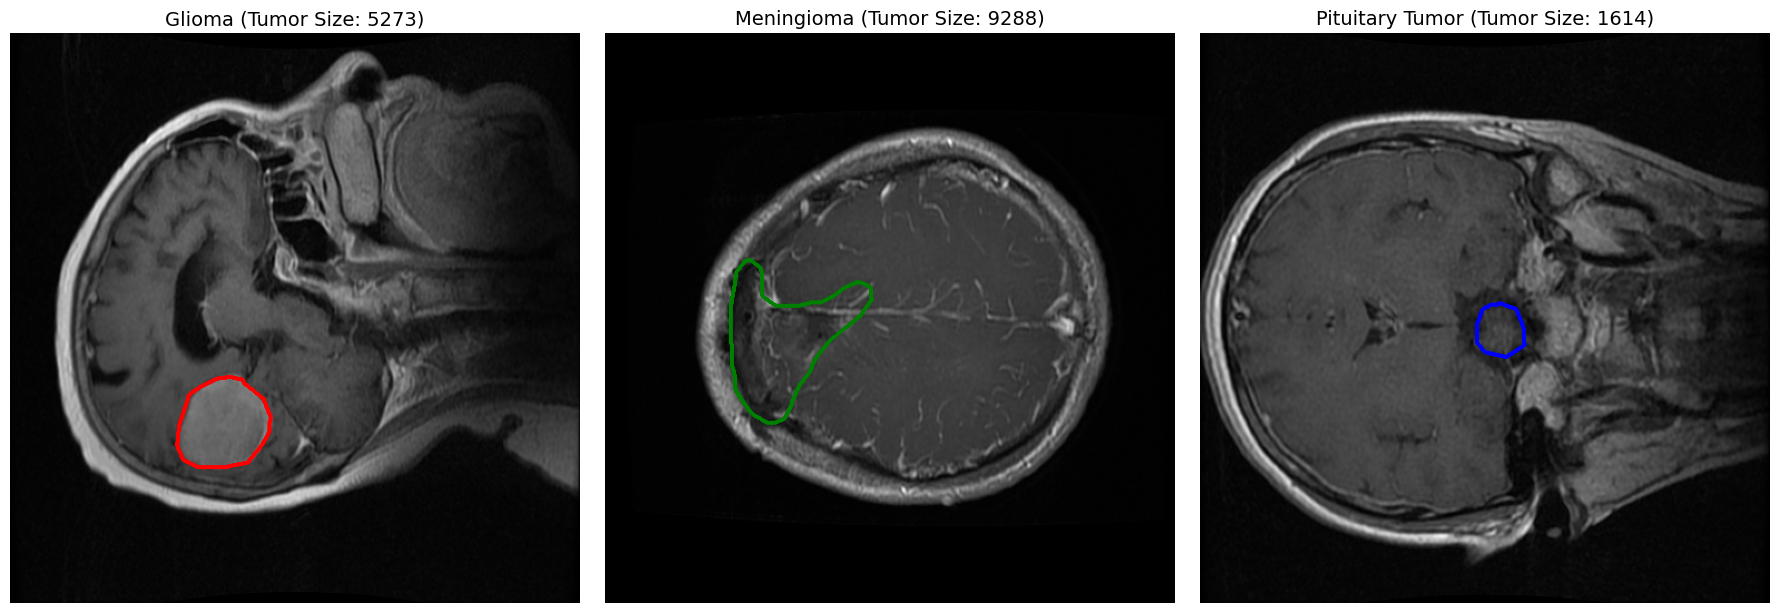

In [ ]:
import os
import h5py
import numpy as np
import glob
import matplotlib.pyplot as plt

input_folder = "/content/drive/MyDrive/brainTumorDataPublic"

label_map = {
    1: 'Glioma',
    2: 'Meningioma',
    3: 'Pituitary Tumor'
}

color_map = {
    1: 'red',
    2: 'green',
    3: 'blue'
}

images_per_label = {}
tumor_sizes = {}

mat_files = glob.glob(os.path.join(input_folder, "*.mat"))

for mat_file in mat_files:
    if len(images_per_label) == 3:
        break

    with h5py.File(mat_file, 'r') as f:
        cjdata = f['cjdata']

        tumor_label = None
        if 'label' in cjdata:
            tumor_label = int(np.array(cjdata['label'][()]).flatten()[0])
        else:
            continue

        if tumor_label in label_map and tumor_label not in images_per_label:
            image = cjdata['image'][()]
            tumor_mask = cjdata['tumorMask'][()]

            image_norm = (image - np.min(image)) / (np.max(image) - np.min(image))

            tumor_size = int(np.sum(tumor_mask))
            tumor_sizes[tumor_label] = tumor_size

            images_per_label[tumor_label] = (image_norm, tumor_mask)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, label in enumerate(sorted(images_per_label.keys())):
    image_norm, tumor_mask = images_per_label[label]
    axs[i].imshow(image_norm, cmap='gray')

    axs[i].contour(tumor_mask, colors=color_map[label], linewidths=2)

    axs[i].set_title(f"{label_map[label]} (Tumor Size: {tumor_sizes[label]})", fontsize=14)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


Segmentasi dengan CNN

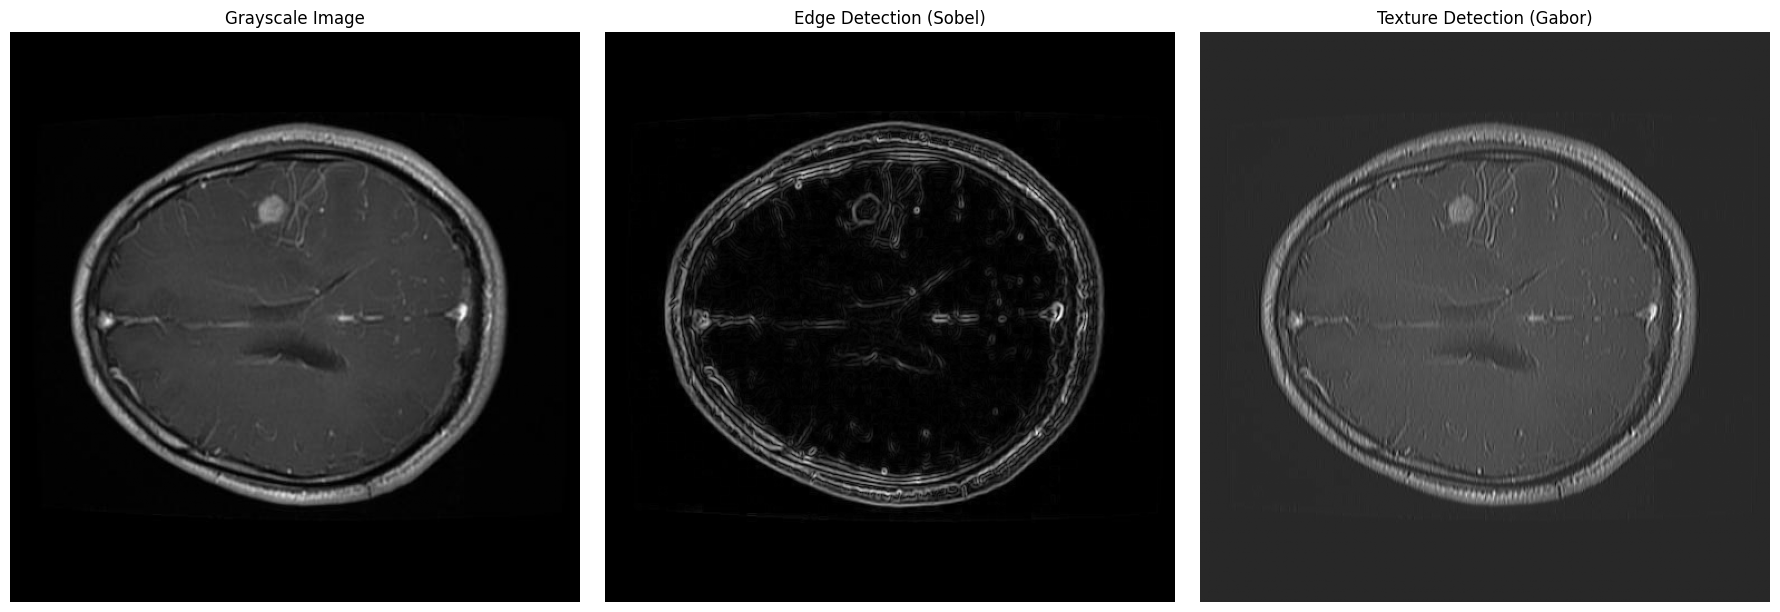

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import sobel, gabor
import os
import glob

image = Image.open(random_image_path).convert("RGB")
image_np = np.array(image)
gray = rgb2gray(image_np)

edges = sobel(gray)
gabor_res, _ = gabor(gray, frequency=0.6)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(gray, cmap='gray')
axs[0].set_title("Grayscale Image")
axs[0].axis("off")

axs[1].imshow(edges, cmap='gray')
axs[1].set_title("Edge Detection (Sobel)")
axs[1].axis("off")

axs[2].imshow(gabor_res.real, cmap='gray')
axs[2].set_title("Texture Detection (Gabor)")
axs[2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
from PIL import Image
from skimage.color import rgb2gray
from skimage.filters import sobel, gabor
from tqdm import tqdm

src_dir = "/content/drive/MyDrive/brainTumorDataNew"
dst_dir = "/content/drive/MyDrive/BrainTumorAug"

classes = ["Glioma", "Meningioma", "Pituitary Tumor"]

for class_name in classes:
    os.makedirs(os.path.join(dst_dir, class_name), exist_ok=True)

def process_and_save(image_path, save_dir, base_name):
    if not os.path.exists(image_path):
        print(f"File tidak ditemukan, dilewati: {image_path}")
        return

    try:
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)
        gray = rgb2gray(image_np)

        edges = sobel(gray)
        gabor_res, _ = gabor(gray, frequency=0.6)

        image.save(os.path.join(save_dir, f"{base_name}_original.jpg"))

        Image.fromarray((gray * 255).astype(np.uint8)).save(os.path.join(save_dir, f"{base_name}_gray.jpg"))
        Image.fromarray((edges * 255).astype(np.uint8)).save(os.path.join(save_dir, f"{base_name}_edge.jpg"))
        Image.fromarray((gabor_res.real * 255).astype(np.uint8)).save(os.path.join(save_dir, f"{base_name}_texture.jpg"))

    except Exception as e:
        print(f"Gagal memproses {image_path}: {e}")

for class_name in classes:
    class_src = os.path.join(src_dir, class_name)
    class_dst = os.path.join(dst_dir, class_name)
    image_list = [f for f in os.listdir(class_src) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for img_name in tqdm(image_list, desc=f"Processing {class_name}"):
        img_path = os.path.join(class_src, img_name)
        base_name = os.path.splitext(img_name)[0]
        process_and_save(img_path, class_dst, base_name)


Processing Pituitary Tumor: 100%|██████████| 930/930 [01:55<00:00,  8.05it/s]


Install Library

In [ ]:
!pip install -q tensorflow numpy scikit-learn imageio

LSTM

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, Reshape,
                                     LSTM, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D)
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

dataset_dir = "/content/drive/MyDrive/brainTumorDataNew"
img_size = 128
batch_size = 32
epochs = 30
num_classes = 3

image_paths = []
labels = []
class_indices = {name: idx for idx, name in enumerate(sorted(os.listdir(dataset_dir)))}

for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('png', 'jpg', 'jpeg')):
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(class_indices[class_name])

X = []
for path in image_paths:
    img = load_img(path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0
    X.append(img)
X = np.array(X)
y = np.array(labels)

X_flat = X.reshape(X.shape[0], -1)
print("Before SMOTE:", np.bincount(y))
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_flat, y)
print("After SMOTE :", np.bincount(y_res))
X_res = X_res.reshape(-1, img_size, img_size, 3)
y_res_cat = to_categorical(y_res, num_classes=num_classes)

X_train, X_val, y_train, y_val = train_test_split(X_res, y_res_cat, test_size=0.2, stratify=y_res, random_state=42)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_res), y=y_res)
class_weights_dict = {i: float(w) for i, w in enumerate(class_weights)}

input_layer = Input(shape=(img_size, img_size, 3))
x = Reshape((img_size, img_size * 3))(input_layer)
x = LSTM(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.4)(x)
output_layer = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_best = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
checkpoint_final = ModelCheckpoint("final_epoch_30_model.h5", save_best_only=False, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weights_dict,
    callbacks=[checkpoint_best, checkpoint_final, early_stop],
    verbose=1
)

Before SMOTE: [ 708 1426  930]
After SMOTE : [1426 1426 1426]
Epoch 1/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.4931 - loss: 0.9801
Epoch 1: val_accuracy improved from -inf to 0.63201, saving model to best_model.h5



Epoch 1: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 60s 491ms/step - accuracy: 0.4938 - loss: 0.9792 - val_accuracy: 0.6320 - val_loss: 0.7379
Epoch 2/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.6525 - loss: 0.7172
Epoch 2: val_accuracy improved from 0.63201 to 0.70678, saving model to best_model.h5



Epoch 2: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 59s 552ms/step - accuracy: 0.6529 - loss: 0.7167 - val_accuracy: 0.7068 - val_loss: 0.6651
Epoch 3/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7422 - loss: 0.6104
Epoch 3: val_accuracy improved from 0.70678 to 0.77453, saving model to best_model.h5



Epoch 3: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 76s 503ms/step - accuracy: 0.7422 - loss: 0.6102 - val_accuracy: 0.7745 - val_loss: 0.5650
Epoch 4/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.7496 - loss: 0.5626
Epoch 4: val_accuracy improved from 0.77453 to 0.78505, saving model to best_model.h5



Epoch 4: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 80s 484ms/step - accuracy: 0.7498 - loss: 0.5623 - val_accuracy: 0.7850 - val_loss: 0.5132
Epoch 5/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.8051 - loss: 0.4717
Epoch 5: val_accuracy improved from 0.78505 to 0.79206, saving model to best_model.h5



Epoch 5: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 485ms/step - accuracy: 0.8050 - loss: 0.4717 - val_accuracy: 0.7921 - val_loss: 0.4778
Epoch 6/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8187 - loss: 0.4466
Epoch 6: val_accuracy improved from 0.79206 to 0.80841, saving model to best_model.h5



Epoch 6: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 490ms/step - accuracy: 0.8186 - loss: 0.4466 - val_accuracy: 0.8084 - val_loss: 0.4649
Epoch 7/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8288 - loss: 0.4002
Epoch 7: val_accuracy did not improve from 0.80841

Epoch 7: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 52s 485ms/step - accuracy: 0.8287 - loss: 0.4003 - val_accuracy: 0.8014 - val_loss: 0.4489
Epoch 8/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.8263 - loss: 0.4197
Epoch 8: val_accuracy improved from 0.80841 to 0.81425, saving model to best_model.h5



Epoch 8: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 485ms/step - accuracy: 0.8263 - loss: 0.4197 - val_accuracy: 0.8143 - val_loss: 0.4314
Epoch 9/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.8546 - loss: 0.3675
Epoch 9: val_accuracy improved from 0.81425 to 0.83995, saving model to best_model.h5



Epoch 9: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 486ms/step - accuracy: 0.8546 - loss: 0.3675 - val_accuracy: 0.8400 - val_loss: 0.4073
Epoch 10/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8626 - loss: 0.3304
Epoch 10: val_accuracy improved from 0.83995 to 0.84229, saving model to best_model.h5



Epoch 10: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 54s 501ms/step - accuracy: 0.8626 - loss: 0.3304 - val_accuracy: 0.8423 - val_loss: 0.3747
Epoch 11/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8654 - loss: 0.3193
Epoch 11: val_accuracy did not improve from 0.84229

Epoch 11: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 86s 537ms/step - accuracy: 0.8654 - loss: 0.3194 - val_accuracy: 0.7932 - val_loss: 0.4503
Epoch 12/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8722 - loss: 0.3136
Epoch 12: val_accuracy improved from 0.84229 to 0.84579, saving model to best_model.h5



Epoch 12: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 81s 529ms/step - accuracy: 0.8722 - loss: 0.3135 - val_accuracy: 0.8458 - val_loss: 0.3745
Epoch 13/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.8857 - loss: 0.2878
Epoch 13: val_accuracy improved from 0.84579 to 0.85397, saving model to best_model.h5



Epoch 13: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 87s 574ms/step - accuracy: 0.8857 - loss: 0.2877 - val_accuracy: 0.8540 - val_loss: 0.3906
Epoch 14/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8993 - loss: 0.2439
Epoch 14: val_accuracy improved from 0.85397 to 0.86799, saving model to best_model.h5



Epoch 14: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 71s 470ms/step - accuracy: 0.8993 - loss: 0.2438 - val_accuracy: 0.8680 - val_loss: 0.3518
Epoch 15/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9095 - loss: 0.2270
Epoch 15: val_accuracy did not improve from 0.86799

Epoch 15: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 83s 480ms/step - accuracy: 0.9095 - loss: 0.2270 - val_accuracy: 0.8575 - val_loss: 0.3586
Epoch 16/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9066 - loss: 0.2439
Epoch 16: val_accuracy did not improve from 0.86799

Epoch 16: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 51s 477ms/step - accuracy: 0.9065 - loss: 0.2440 - val_accuracy: 0.8271 - val_loss: 0.3897
Epoch 17/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9118 - loss: 0.2109
Epoch 17: val_accuracy improved from 0.86799 to 0.87850, saving model to best_model.h5



Epoch 17: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 482ms/step - accuracy: 0.9119 - loss: 0.2109 - val_accuracy: 0.8785 - val_loss: 0.3334
Epoch 18/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9165 - loss: 0.2133
Epoch 18: val_accuracy did not improve from 0.87850

Epoch 18: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 84s 499ms/step - accuracy: 0.9166 - loss: 0.2132 - val_accuracy: 0.8610 - val_loss: 0.3870
Epoch 19/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9294 - loss: 0.1774
Epoch 19: val_accuracy did not improve from 0.87850

Epoch 19: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 81s 489ms/step - accuracy: 0.9294 - loss: 0.1775 - val_accuracy: 0.8727 - val_loss: 0.3629
Epoch 20/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9322 - loss: 0.1701
Epoch 20: val_accuracy improved from 0.87850 to 0.89836, saving model to best_model.h5



Epoch 20: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 490ms/step - accuracy: 0.9322 - loss: 0.1701 - val_accuracy: 0.8984 - val_loss: 0.2740
Epoch 21/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9449 - loss: 0.1361
Epoch 21: val_accuracy did not improve from 0.89836

Epoch 21: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 86s 530ms/step - accuracy: 0.9449 - loss: 0.1362 - val_accuracy: 0.8972 - val_loss: 0.3059
Epoch 22/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9494 - loss: 0.1317
Epoch 22: val_accuracy improved from 0.89836 to 0.91005, saving model to best_model.h5



Epoch 22: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 530ms/step - accuracy: 0.9494 - loss: 0.1317 - val_accuracy: 0.9100 - val_loss: 0.2590
Epoch 23/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9604 - loss: 0.1157
Epoch 23: val_accuracy did not improve from 0.91005

Epoch 23: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 77s 483ms/step - accuracy: 0.9603 - loss: 0.1159 - val_accuracy: 0.8925 - val_loss: 0.3676
Epoch 24/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9427 - loss: 0.1451
Epoch 24: val_accuracy improved from 0.91005 to 0.91238, saving model to best_model.h5



Epoch 24: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 52s 484ms/step - accuracy: 0.9427 - loss: 0.1450 - val_accuracy: 0.9124 - val_loss: 0.2731
Epoch 25/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9606 - loss: 0.1149
Epoch 25: val_accuracy improved from 0.91238 to 0.91472, saving model to best_model.h5



Epoch 25: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 482ms/step - accuracy: 0.9606 - loss: 0.1149 - val_accuracy: 0.9147 - val_loss: 0.2485
Epoch 26/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9694 - loss: 0.0819
Epoch 26: val_accuracy did not improve from 0.91472

Epoch 26: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 483ms/step - accuracy: 0.9694 - loss: 0.0821 - val_accuracy: 0.9100 - val_loss: 0.3032
Epoch 27/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9635 - loss: 0.0943
Epoch 27: val_accuracy did not improve from 0.91472

Epoch 27: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 81s 472ms/step - accuracy: 0.9635 - loss: 0.0943 - val_accuracy: 0.8949 - val_loss: 0.3224
Epoch 28/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9612 - loss: 0.0967
Epoch 28: val_accuracy did not improve from 0.91472

Epoch 28: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 473ms/step - accuracy: 0.9612 - loss: 0.0967 - val_accuracy: 0.9147 - val_loss: 0.2829
Epoch 29/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9750 - loss: 0.0699
Epoch 29: val_accuracy did not improve from 0.91472

Epoch 29: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 470ms/step - accuracy: 0.9750 - loss: 0.0699 - val_accuracy: 0.9147 - val_loss: 0.2738
Epoch 30/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.9697 - loss: 0.0764
Epoch 30: val_accuracy did not improve from 0.91472

Epoch 30: saving model to final_epoch_30_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 101s 654ms/step - accuracy: 0.9696 - loss: 0.0765 - val_accuracy: 0.8984 - val_loss: 0.3380


LSTM + Augmentasi

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, Reshape,
                                     LSTM, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D)
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

dataset_dir = "/content/drive/MyDrive/BrainTumorAug"
img_size = 128
batch_size = 32
epochs = 30
num_classes = 3

image_paths = []
labels = []
class_indices = {name: idx for idx, name in enumerate(sorted(os.listdir(dataset_dir)))}

for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('png', 'jpg', 'jpeg')):
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(class_indices[class_name])

X = []
for path in image_paths:
    img = load_img(path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0
    X.append(img)
X = np.array(X)
y = np.array(labels)

X_flat = X.reshape(X.shape[0], -1)
print("Before SMOTE:", np.bincount(y))
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_flat, y)
print("After SMOTE :", np.bincount(y_res))
X_res = X_res.reshape(-1, img_size, img_size, 3)
y_res_cat = to_categorical(y_res, num_classes=num_classes)

X_train, X_val, y_train, y_val = train_test_split(X_res, y_res_cat, test_size=0.2, stratify=y_res, random_state=42)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_res), y=y_res)
class_weights_dict = {i: float(w) for i, w in enumerate(class_weights)}

input_layer = Input(shape=(img_size, img_size, 3))
x = Reshape((img_size, img_size * 3))(input_layer)
x = LSTM(128, return_sequences=True)(x)
x = LayerNormalization()(x)
x = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.4)(x)
output_layer = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_best = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
checkpoint_final = ModelCheckpoint("final_epoch_30_model.h5", save_best_only=False, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weights_dict,
    callbacks=[checkpoint_best, checkpoint_final, early_stop],
    verbose=1
)

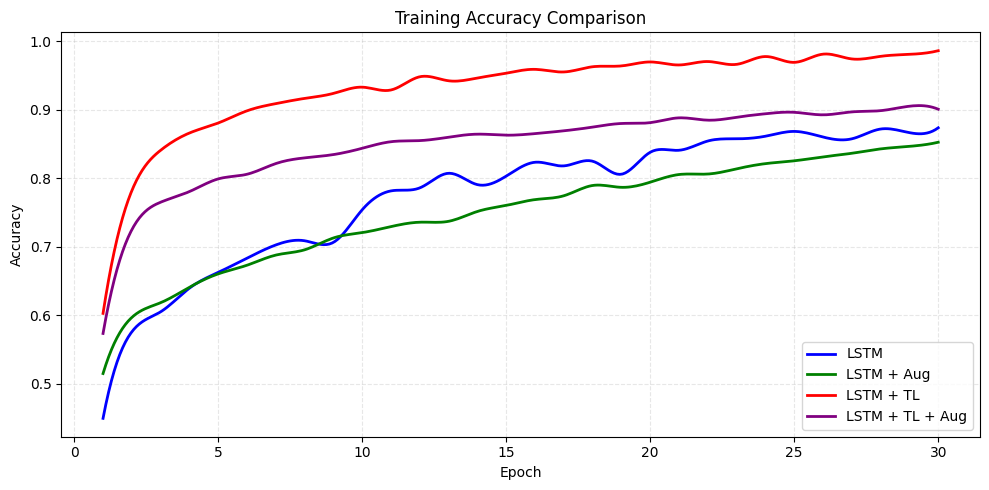

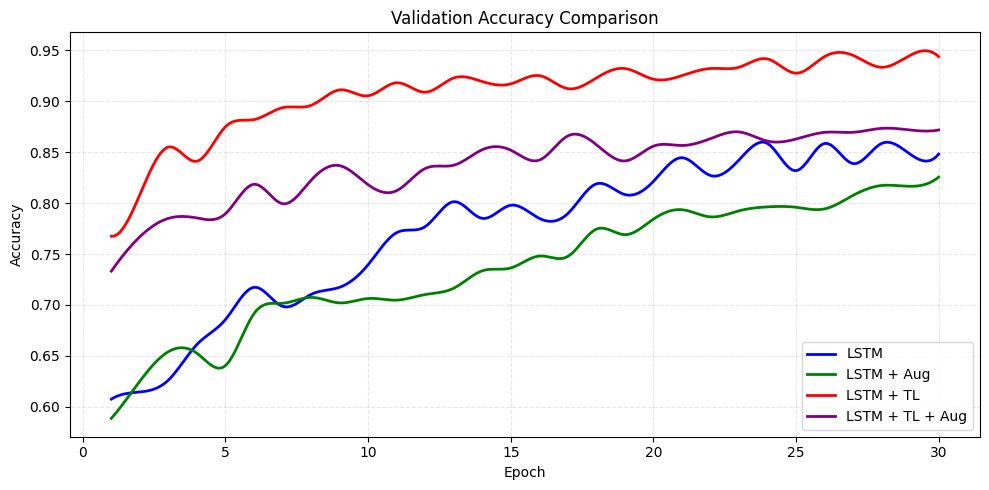

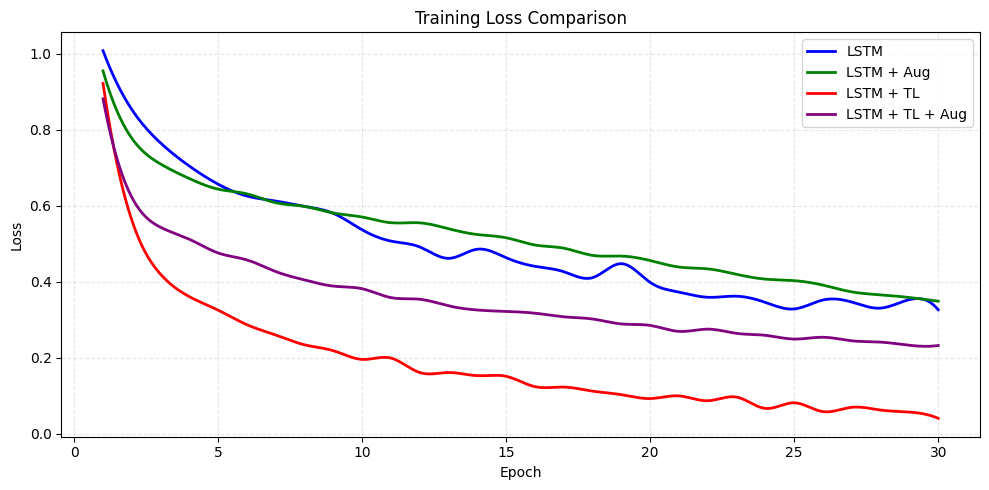

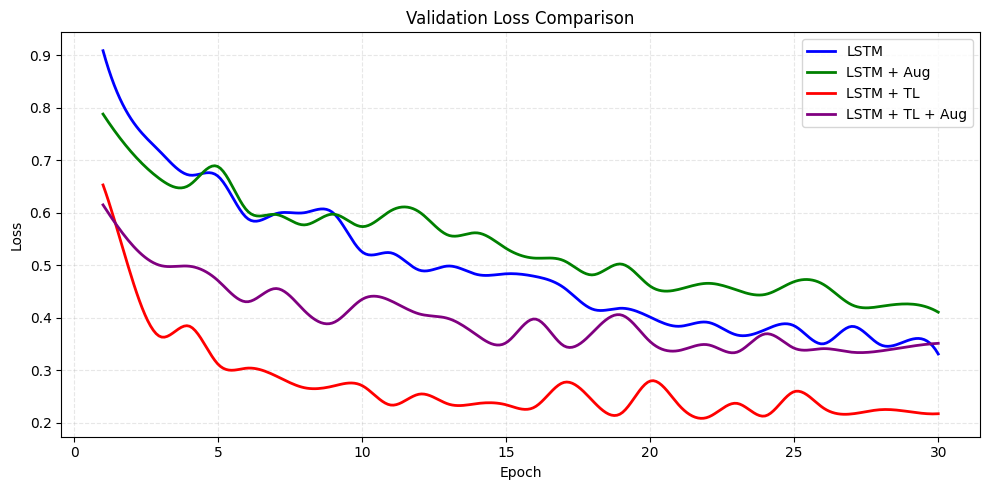

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Data dari 4 model yang telah diekstrak sebelumnya
accuracy_LSTM_np = np.array([0.4497, 0.576, 0.6052, 0.6397, 0.6628, 0.6835, 0.7028, 0.7089, 0.7066, 0.7542, 0.7817, 0.7861, 0.8074, 0.7908, 0.8033, 0.8235, 0.8182, 0.825, 0.806, 0.8381, 0.841, 0.8545, 0.8577, 0.8615, 0.8685, 0.8603, 0.8577, 0.872, 0.8667, 0.8738])
val_accuracy_LSTM_np = np.array([0.6075, 0.6145, 0.6262, 0.6612, 0.6857, 0.7173, 0.6986, 0.7103, 0.7173, 0.7395, 0.771, 0.7769, 0.8014, 0.785, 0.7979, 0.785, 0.7897, 0.8189, 0.8084, 0.8213, 0.8446, 0.8271, 0.8423, 0.8586, 0.8318, 0.8586, 0.8388, 0.8586, 0.8481, 0.8481])
loss_LSTM_np = np.array([1.0081, 0.8533, 0.765, 0.7042, 0.6565, 0.6254, 0.6123, 0.5982, 0.5798, 0.5364, 0.5068, 0.4913, 0.4614, 0.4855, 0.463, 0.4404, 0.4262, 0.4106, 0.4475, 0.398, 0.3726, 0.3589, 0.3618, 0.3454, 0.3282, 0.3518, 0.3463, 0.3304, 0.3528, 0.326])
val_loss_LSTM_np = np.array([0.909, 0.7768, 0.7155, 0.6719, 0.6694, 0.5899, 0.5983, 0.6003, 0.5994, 0.5253, 0.5237, 0.4904, 0.4986, 0.4823, 0.4838, 0.4788, 0.4574, 0.4163, 0.4181, 0.4011, 0.3837, 0.3913, 0.3672, 0.3774, 0.3846, 0.3502, 0.3835, 0.3483, 0.3577, 0.3309])

accuracy_LSTM_Aug_np = np.array([0.5151, 0.597, 0.6185, 0.6411, 0.6606, 0.6732, 0.688, 0.6957, 0.713, 0.7208, 0.7296, 0.736, 0.7373, 0.7517, 0.7605, 0.769, 0.7746, 0.7896, 0.7869, 0.7944, 0.8056, 0.8063, 0.8139, 0.8215, 0.8256, 0.8314, 0.8366, 0.843, 0.8467, 0.8527])
val_accuracy_LSTM_Aug_np = np.array([0.5886, 0.6252, 0.6541, 0.6525, 0.6404, 0.6915, 0.7016, 0.7074, 0.702, 0.7063, 0.7047, 0.7102, 0.7164, 0.7335, 0.7363, 0.748, 0.7476, 0.7744, 0.769, 0.7842, 0.7935, 0.7865, 0.7924, 0.7963, 0.7959, 0.7943, 0.8076, 0.8173, 0.8165, 0.8255])
loss_LSTM_Aug_np = np.array([0.9548, 0.7775, 0.7097, 0.6714, 0.6435, 0.6312, 0.6078, 0.5982, 0.5808, 0.5702, 0.5552, 0.5549, 0.5393, 0.5241, 0.5156, 0.4965, 0.4882, 0.4692, 0.4674, 0.4556, 0.4385, 0.4337, 0.4193, 0.4067, 0.4027, 0.3909, 0.3731, 0.3654, 0.3583, 0.3485])
val_loss_LSTM_Aug_np = np.array([0.7882, 0.7148, 0.6635, 0.6529, 0.6878, 0.6043, 0.5969, 0.577, 0.5974, 0.5737, 0.6042, 0.6009, 0.5571, 0.5617, 0.532, 0.5136, 0.5088, 0.4817, 0.5023, 0.4601, 0.4542, 0.4656, 0.4529, 0.4445, 0.4688, 0.4639, 0.4246, 0.4216, 0.4262, 0.4106])

accuracy_LSTM_TL_np = np.array([0.6029, 0.782, 0.841, 0.8662, 0.8808, 0.8986, 0.9091, 0.9167, 0.924, 0.9331, 0.929, 0.9483, 0.9424, 0.9465, 0.9535, 0.9591, 0.9553, 0.9629, 0.9641, 0.9699, 0.9655, 0.9705, 0.9664, 0.9778, 0.9693, 0.9813, 0.9743, 0.9781, 0.981, 0.9863])
val_accuracy_LSTM_TL_np = np.array([0.7675, 0.8084, 0.8551, 0.8411, 0.875, 0.882, 0.8937, 0.896, 0.9112, 0.9054, 0.9182, 0.9089, 0.9229, 0.9194, 0.9171, 0.9252, 0.9124, 0.9229, 0.9322, 0.9217, 0.9252, 0.9322, 0.9334, 0.9416, 0.9276, 0.9439, 0.9451, 0.9334, 0.9451, 0.9439])
loss_LSTM_TL_np = np.array([0.922, 0.5618, 0.4194, 0.3604, 0.3249, 0.2866, 0.2594, 0.2337, 0.2182, 0.1954, 0.1988, 0.1607, 0.1608, 0.1525, 0.1508, 0.1236, 0.1225, 0.1118, 0.1025, 0.0923, 0.0993, 0.0865, 0.0961, 0.0663, 0.0811, 0.0579, 0.0693, 0.062, 0.0568, 0.0402])
val_loss_LSTM_TL_np = np.array([0.6531, 0.4755, 0.3637, 0.3839, 0.311, 0.3039, 0.2892, 0.2665, 0.2698, 0.2705, 0.2335, 0.2545, 0.2353, 0.2365, 0.234, 0.2301, 0.2767, 0.2417, 0.218, 0.2794, 0.2332, 0.2103, 0.2369, 0.2129, 0.2592, 0.2284, 0.2167, 0.2248, 0.2209, 0.217])

accuracy_LSTM_TL_Aug_np = np.array([0.5736, 0.725, 0.7652, 0.7807, 0.7992, 0.806, 0.8216, 0.8299, 0.8347, 0.8439, 0.8535, 0.8551, 0.8601, 0.8645, 0.863, 0.8653, 0.8694, 0.8748, 0.8801, 0.8813, 0.8883, 0.8849, 0.8892, 0.8943, 0.8964, 0.8927, 0.897, 0.8988, 0.9053, 0.9009])
val_accuracy_LSTM_TL_Aug_np = np.array([0.7332, 0.767, 0.785, 0.7854, 0.7896, 0.8185, 0.7994, 0.8224, 0.8368, 0.8181, 0.8122, 0.834, 0.8372, 0.8524, 0.852, 0.8422, 0.866, 0.8574, 0.8414, 0.8559, 0.8566, 0.8633, 0.8699, 0.8609, 0.8629, 0.8695, 0.8695, 0.8734, 0.8718, 0.8718])
loss_LSTM_TL_Aug_np = np.array([0.8812, 0.6221, 0.5431, 0.5116, 0.4755, 0.4572, 0.4265, 0.4045, 0.3883, 0.3814, 0.358, 0.3537, 0.3364, 0.3254, 0.3216, 0.317, 0.3074, 0.3017, 0.2887, 0.2848, 0.2691, 0.2751, 0.2639, 0.2588, 0.2489, 0.2537, 0.2443, 0.2409, 0.2325, 0.232])
val_loss_LSTM_TL_Aug_np = np.array([0.6151, 0.5396, 0.4995, 0.4982, 0.4704, 0.4304, 0.4557, 0.4129, 0.3907, 0.4352, 0.4321, 0.407, 0.3983, 0.3662, 0.3525, 0.3976, 0.3465, 0.3721, 0.4052, 0.3543, 0.3375, 0.3485, 0.3342, 0.3693, 0.3419, 0.3411, 0.3343, 0.3367, 0.3451, 0.3512])

# Kumpulkan semua data ke dalam kamus (dictionary)
models = {
    "LSTM": {
        "accuracy": accuracy_LSTM_np,
        "val_accuracy": val_accuracy_LSTM_np,
        "loss": loss_LSTM_np,
        "val_loss": val_loss_LSTM_np
    },
    "LSTM + Aug": {
        "accuracy": accuracy_LSTM_Aug_np,
        "val_accuracy": val_accuracy_LSTM_Aug_np,
        "loss": loss_LSTM_Aug_np,
        "val_loss": val_loss_LSTM_Aug_np
    },
    "LSTM + TL": {
        "accuracy": accuracy_LSTM_TL_np,
        "val_accuracy": val_accuracy_LSTM_TL_np,
        "loss": loss_LSTM_TL_np,
        "val_loss": val_loss_LSTM_TL_np
    },
    "LSTM + TL + Aug": {
        "accuracy": accuracy_LSTM_TL_Aug_np,
        "val_accuracy": val_accuracy_LSTM_TL_Aug_np,
        "loss": loss_LSTM_TL_Aug_np,
        "val_loss": val_loss_LSTM_TL_Aug_np
    },
}

# Tentukan epoch dan titik untuk smoothing
epochs = np.arange(1, 31)
xnew = np.linspace(epochs.min(), epochs.max(), 300)

colors = ['blue', 'green', 'red', 'purple']
model_names = list(models.keys())

# ---
### Perbandingan Akurasi Latihan (Training Accuracy)

plt.figure(figsize=(10, 5))
for i, name in enumerate(model_names):
    data = models[name]
    acc_spline = make_interp_spline(epochs, data["accuracy"])(xnew)
    plt.plot(xnew, acc_spline, label=name, color=colors[i], linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Comparison")
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# ---
### Perbandingan Akurasi Validasi (Validation Accuracy)

plt.figure(figsize=(10, 5))
for i, name in enumerate(model_names):
    data = models[name]
    val_acc_spline = make_interp_spline(epochs, data["val_accuracy"])(xnew)
    plt.plot(xnew, val_acc_spline, label=name, color=colors[i], linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# ---
### Perbandingan Loss Latihan (Training Loss)

plt.figure(figsize=(10, 5))
for i, name in enumerate(model_names):
    data = models[name]
    loss_spline = make_interp_spline(epochs, data["loss"])(xnew)
    plt.plot(xnew, loss_spline, label=name, color=colors[i], linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# ---
### Perbandingan Loss Validasi (Validation Loss)

plt.figure(figsize=(10, 5))
for i, name in enumerate(model_names):
    data = models[name]
    val_loss_spline = make_interp_spline(epochs, data["val_loss"])(xnew)
    plt.plot(xnew, val_loss_spline, label=name, color=colors[i], linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss Comparison")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()